In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
env.action_space.n

2

In [23]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        A = np.ones(nA)*(epsilon/nA)
        best_action = np.argmax(Q[observation])
        A[best_action] += 1-epsilon
        return A
    return policy_fn

In [73]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for episode_i in range(num_episodes):
        #Part 1 : Generating an episode
        episode = []
        state  = env.reset()
        for i in range(100):
            probs = policy(state)
            action = np.random.choice(len(probs),p=probs)
            next_state, reward, episode_complete, _  = env.step(action)
            episode.append((state,action,reward))
            state = next_state
            
            if episode_complete:
                break
        
        #Part2 : The On-Policy MC Control for eps-soft policy
        
        G = 0
        
        SA_pairs = [(state,action) for (state,action,_) in episode]
        for i,step in enumerate(episode):
            #step is a sequence of SAR
            curr_SA = (step[0],step[1])
            
            #Creating a State and Action Lookup table for checking existence of the next sequence
           
            first_match_index = next(j for j,mini_SAR in enumerate(episode) if (mini_SAR[0] == step[0] and mini_SAR[1] == step[1])) 
            for wow in episode[first_match_index:]:
                curr_SA_wow = (wow[0], wow[1])
                G = discount_factor*G + wow[2]
            returns_sum[curr_SA] += G
            returns_count[curr_SA] += 1
            Q[step[0]][step[1]] = returns_sum[curr_SA] / returns_count[curr_SA]
            #best_action = np.argmax(Q[step[0]])
                
                #Changing policy now
                
                #policy = np.ones(len(Q[step[0]])) * epsilon / len(Q[step[0]])
                #len(Q[step[0]]) is the number of actions possible from the current state S_t.
                #policy[best_action] += 1-epsilon
                
                
                
            
                        
    
    # Implement this!
    
    return Q, policy

In [74]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

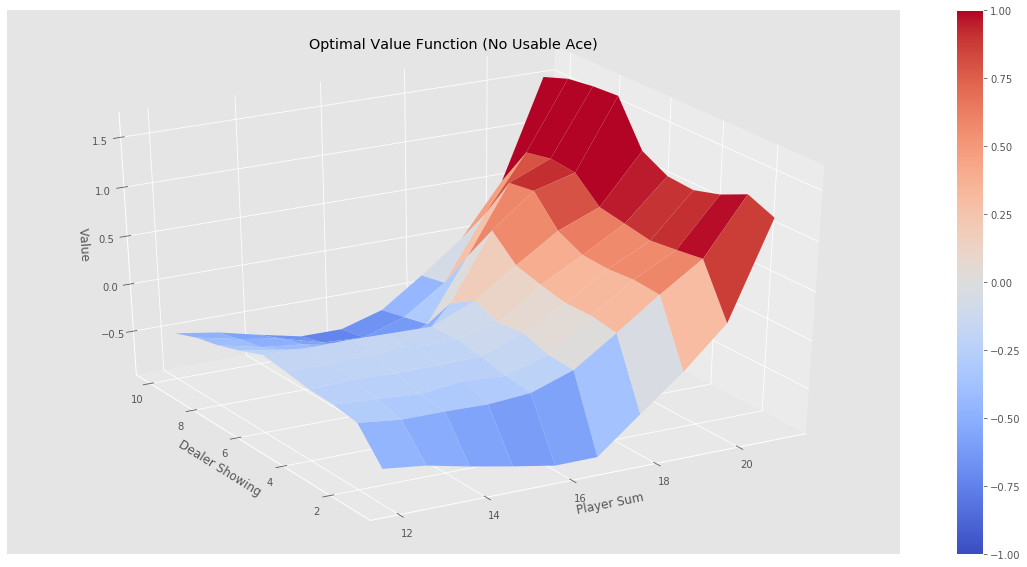

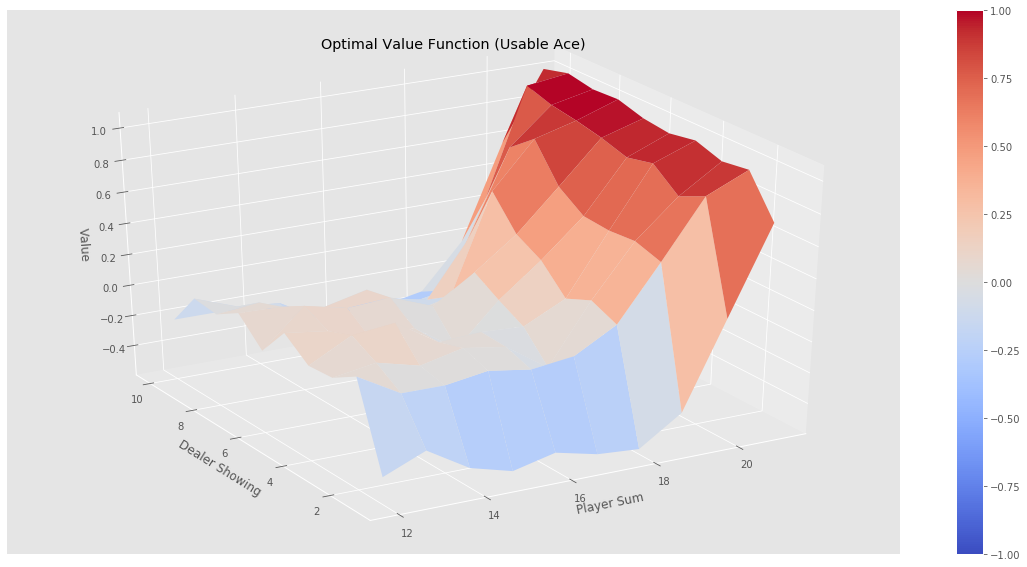

In [75]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [69]:
np.delete?

Signature: np.delete(arr, obj, axis=None)
Docstring:
Return a new array with sub-arrays along an axis deleted. For a one
dimensional array, this returns those entries not returned by
`arr[obj]`.

Parameters
----------
arr : array_like
  Input array.
obj : slice, int or array of ints
  Indicate which sub-arrays to remove.
axis : int, optional
  The axis along which to delete the subarray defined by `obj`.
  If `axis` is None, `obj` is applied to the flattened array.

Returns
-------
out : ndarray
    A copy of `arr` with the elements specified by `obj` removed. Note
    that `delete` does not occur in-place. If `axis` is None, `out` is
    a flattened array.

See Also
--------
insert : Insert elements into an array.
append : Append elements at the end of an array.

Notes
-----
Often it is preferable to use a boolean mask. For example:

>>> mask = np.ones(len(arr), dtype=bool)
>>> mask[[0,2,4]] = False
>>> result = arr[mask,...]

Is equivalent to `np.delete(arr, [0,2,4], axis=0)`, but al